In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def redistribute_force(F, L, alpha, F_thr, neighborhood='moore'):
    # Create a copy of the forces to store the new values
    F_new = np.copy(F)
    # List of active sites
    active_sites = []

    # Find active sites
    for i in range(L):
        for j in range(L):
            if F[i, j] >= F_thr:
                active_sites.append((i, j))

    # Redistribute forces from active sites
    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j]

        # Define the neighborhood for force redistribution
        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        else:  # von Neumann neighborhood
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

        # count no of neighbors 
        neighbors_count = 0    
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                neighbors_count += 1
        
        # Redistribute the force to the neighbors
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute)/neighbors_count

        # Set the force of the active site to zero
        F_new[i, j] = 1

    return F_new, active_sites

def simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore'):
    # Initialize the grid with random forces
    F = np.random.rand(L, L) * F_thr
    initial_state = np.copy(F)

    active = True
    active_sites_count = 0
    active_sites_array = []
    while active:
        # Redistribute forces and get list of active sites
        F, active_sites = redistribute_force(F, L, alpha, F_thr, neighborhood)
        # If there are no active sites, break the loop
        active = len(active_sites) > 0
        active_sites_count += len(active_sites)

        if not active and n_additions > 0:
            # Locate site with the block closest to slip
            i, j = np.unravel_index(np.argmin(F_thr - F), F.shape)
            # Add the difference to all sites
            F += (F_thr - F[i, j])
            n_additions -= 1
            active_sites_array.append(active_sites_count)
            active_sites_count = 0
            active = True

    return initial_state, F, active_sites_array

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Initial state visualization
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    # Final state visualization
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    # Overall title and show
    plt.suptitle(title)
    plt.show()


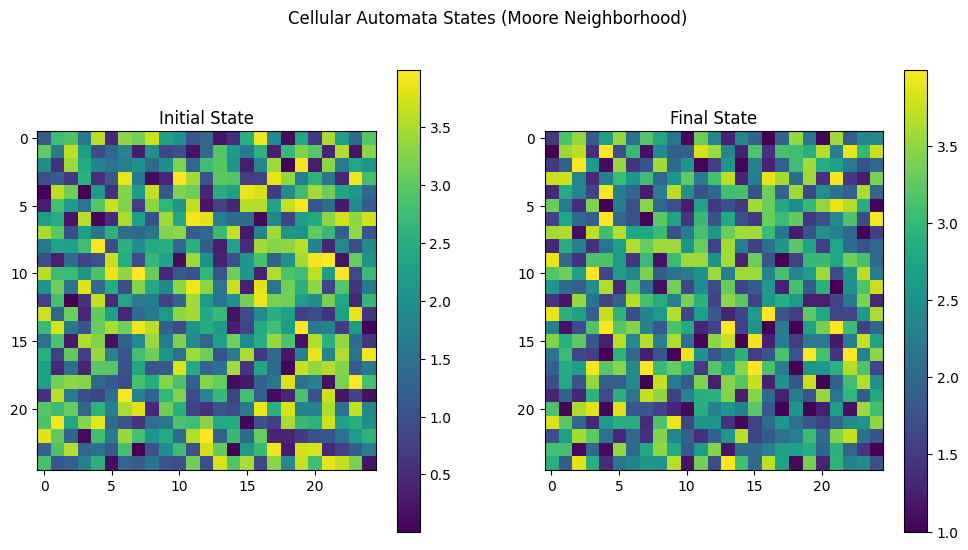

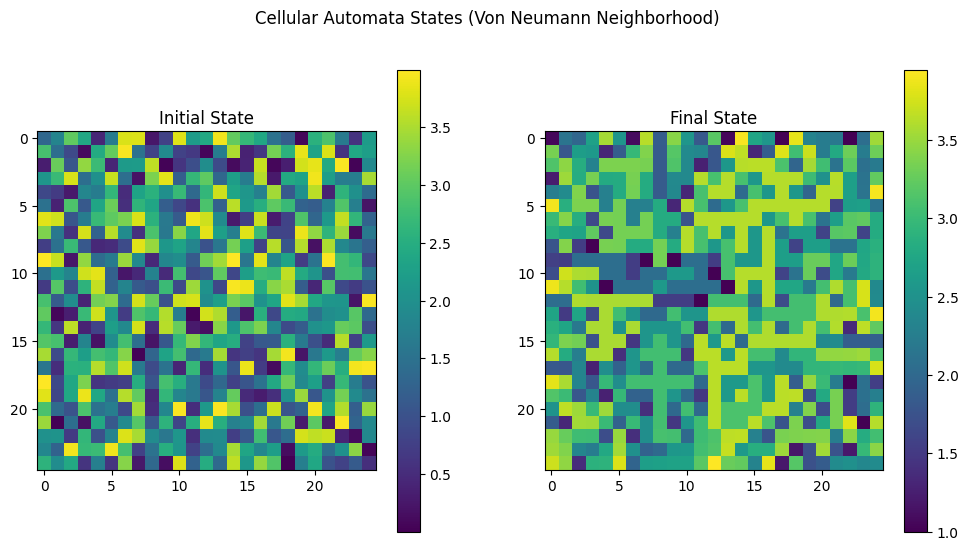

In [3]:
# Parameters
L = 25  # Size of the lattice
alpha = 0.5  # Coupling constant
F_thr = 4.0  # Threshold force
n_additions = 10000 # Number of additions of force to the system

# Run the simulation for Moore neighborhood
initial_state_moore, final_state_moore, active_sites_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')

# Visualize the initial and final states for Moore neighborhood
visualize_states(initial_state_moore, final_state_moore, title='Cellular Automata States (Moore Neighborhood)')

# Run the simulation for Von Neumann neighborhood
initial_state_von, final_state_von, active_sites_von = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='von_neumann')

# Visualize the initial and final states for Von Neumann neighborhood
visualize_states(initial_state_von, final_state_von, title='Cellular Automata States (Von Neumann Neighborhood)')

In [4]:
print(active_sites_von)

[0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 3, 2, 1, 2, 2, 1, 1, 5, 1, 1, 3, 1, 2, 1, 1, 1, 1, 4, 1, 4, 2, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 2, 1, 4, 3, 3, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 3, 2, 2, 1, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 4, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 2, 2, 4, 2, 2, 1, 1, 3, 2, 1, 1, 6, 1, 1, 2, 2, 4, 2, 2, 1, 1, 1, 4, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 3, 1, 2, 4, 2, 1, 2, 1, 1, 1, 1, 7, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 7, 6, 2, 3, 2, 2, 4, 2, 1, 1, 1, 5, 2, 2, 2, 1, 3, 1, 2, 1, 3, 8, 1, 2, 6, 5, 3, 1, 2, 1, 1, 1, 3, 5, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 6, 1, 1, 1, 1, 2, 1, 1, 2, 4, 2, 1, 2, 1, 3, 1, 2, 3, 1, 1, 2, 1, 5, 1, 7, 1, 1, 1, 2, 4, 4, 11, 1, 3, 2, 14, 1, 1, 8, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 12, 1, 2, 7, 1, 2, 3, 9, 2, 4, 1, 4, 1, 1, 1, 5, 5, 3, 1, 3, 3, 1, 1, 4, 1, 1, 5, 1, 7, 1, 2, 1, 2, 5, 1, 1, 1, 1, 1, 1, 3, 1, 

Counter({1: 6035, 2: 1316, 3: 625, 5: 347, 4: 301, 7: 211, 6: 134, 9: 120, 8: 93, 14: 86, 24: 49, 22: 47, 11: 46, 19: 46, 10: 44, 41: 43, 37: 43, 47: 43, 16: 42, 74: 36, 13: 29, 12: 26, 42: 21, 20: 19, 48: 17, 18: 13, 15: 13, 54: 12, 36: 11, 23: 10, 26: 10, 45: 10, 17: 9, 32: 9, 34: 9, 31: 8, 46: 8, 21: 7, 55: 7, 33: 7, 28: 4, 35: 4, 27: 3, 43: 3, 49: 3, 25: 2, 39: 2, 30: 2, 29: 2, 72: 2, 73: 2, 0: 1, 40: 1, 51: 1, 60: 1, 62: 1, 63: 1, 64: 1, 69: 1, 38: 1})


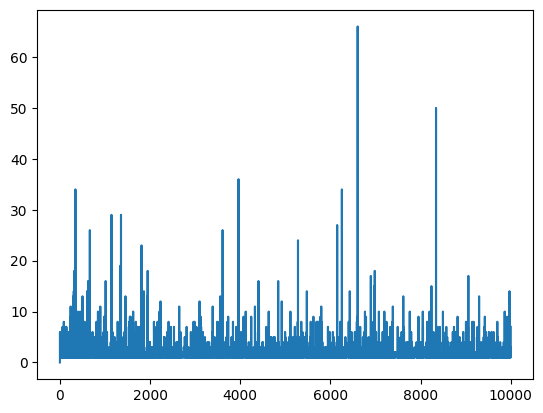

In [5]:
plt.plot(active_sites_moore, label='Moore')
from collections import Counter
occurrences_counter = Counter(active_sites_von)
print(occurrences_counter)

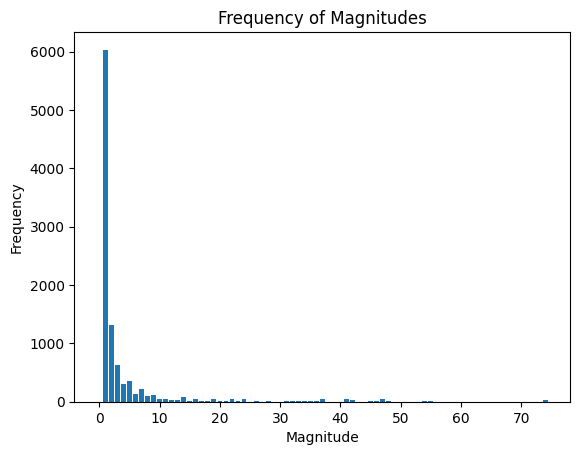

In [6]:
sorted_data = dict(sorted(occurrences_counter.items()))
magnitudes = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.bar(magnitudes, frequencies)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Frequency of Magnitudes')
plt.show()

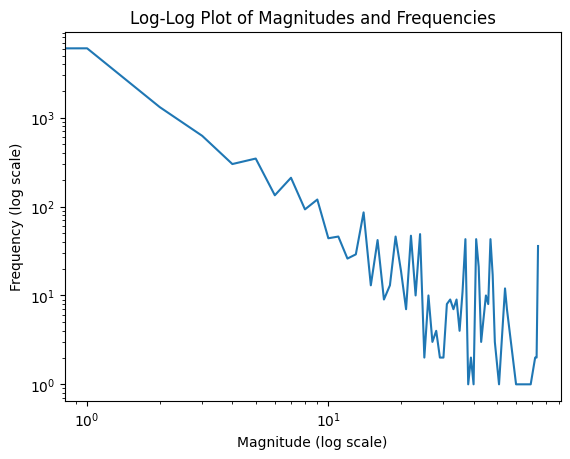

In [7]:
plt.loglog(magnitudes, frequencies)
plt.xlabel('Magnitude (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Log-Log Plot of Magnitudes and Frequencies')
plt.show()

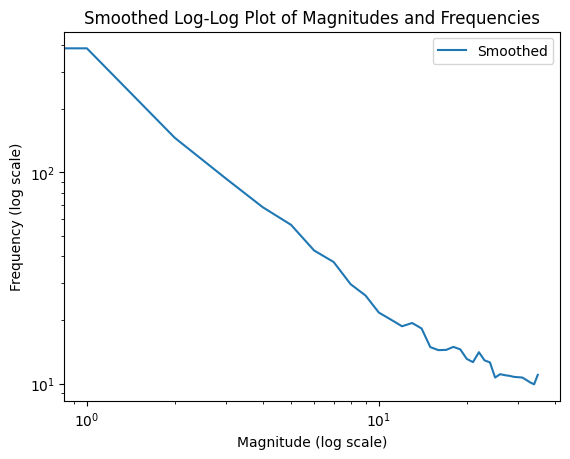

In [15]:
window_size = 25
smoothed_frequencies = np.convolve(frequencies, np.ones(window_size) / window_size, mode='valid')

# Plotting log-log
plt.loglog(magnitudes[:len(smoothed_frequencies)], smoothed_frequencies,label='Smoothed')
plt.xlabel('Magnitude (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Smoothed Log-Log Plot of Magnitudes and Frequencies')
plt.legend()
plt.show()